In [2]:
import pandas as pd
from funmirtar.utils.data_processing import parse_UCSC_utr_txt

CONSERVATION_PATH = '../../data/conservation/hg19.100way.phyloP100way.bw'

UTR_DF_MIRNA_FC_CHR_PATH = '../../data/processed/GRCh37.p13 hg19/UCSC/3utr.sequences.refseq_id.mirna_fc.pkl'
df = pd.read_pickle(UTR_DF_MIRNA_FC_CHR_PATH)

UTR_DF_MIRNA_FC_CHR_CONSERVATION_PATH = '../../data/conservation/hg19/UCSC/3utr.sequences.refseq_id.mirna_fc.chr.conservation.pkl'

In [3]:
import pyBigWig

def get_conservation(bw_file, chrom, ensembl_start, ensembl_end):
    # Adjust Ensembl coordinates to UCSC format (0-based, half-open at the end)
    ucsc_start = ensembl_start - 1
    ucsc_end = ensembl_end  # The end coordinate remains the same
    
    if not 'chr' in chrom:
        chrom = 'chr' + chrom

    conservation_scores = bw_file.values(chrom, ucsc_start, ucsc_end)

    return conservation_scores

In [4]:
df = df.rename({'Start':'utr3_start', 'End':'utr3_end', 'Chromosome':'chromosome', 'Strand':'strand'}, axis=1)
df[['utr3_start', 'utr3_end', 'strand', 'chromosome']]

,utr3_start,utr3_end,strand,chromosome
1,121177252.0,121177811.0,+,chr12
4,108018118.0,108018330.0,+,chr11
6,73685998.0,73690399.0,+,chr14
10,48252799.0,48252810.0,+,chr17
14,178351928.0,178352861.0,-,chr4
...,...,...,...,...
20599,100800127.0,100801211.0,-,chr14
20601,176524678.0,176525145.0,+,chr5
20602,120900279.0,120900753.0,-,chr10
20605,108676665.0,108679274.0,-,chr1


In [5]:
import numpy as np

bw_file = pyBigWig.open(CONSERVATION_PATH)


df_conservation = []
errors = []
error_loci = []

for row in df.iterrows():
    chrom = row[1].chromosome
    ensembl_start = row[1].utr3_start  # Ensembl coordinates (1-based, inclusive)
    ensembl_end = row[1].utr3_end  # Ensembl coordinates (1-based, inclusive)
    
    strand = row[1].strand
    
    # if ensembl_start != ensembl_start:
    if np.isnan(ensembl_start):
        df_conservation.append([])
        continue
    if isinstance(ensembl_start, float) or isinstance(ensembl_start, int):
        try:
            ensembl_start = [int(ensembl_start)]
        except:
            print(ensembl_start)
        ensembl_end = [int(ensembl_end)]
    else:
        ensembl_start = [int(x) for x in ensembl_start.split(';')]
        ensembl_end = [int(x) for x in ensembl_end.split(';')]
    
    if len(ensembl_start) > 1:
        ensembl_start.sort()
        ensembl_end.sort()
    
    row_conservation = []
    for start, end in zip(ensembl_start, ensembl_end):
        try:
            exon_conservation = get_conservation(bw_file, chrom, start, end)
            row_conservation.extend(exon_conservation)
        except RuntimeError as er:
            errors.append(er)
            error_loci.append((start, end, chrom))

    # TODO should I do this?
    # if strand < 0:
    #     row_conservation = np.flip(row_conservation)
        
    df_conservation.append(row_conservation)


bw_file.close()
df['conservation_phylo'] = df_conservation

In [6]:
df.columns

Index(['RefSeq ID', 'Gene symbol', 'hsa-miR-16-5p', 'hsa-miR-106b-5p',
       'hsa-miR-200a-3p', 'hsa-miR-200b-3p', 'hsa-miR-215-5p', 'hsa-let-7c-5p',
       'hsa-miR-103a-3p', 'knownGene.name', 'knownGene.chrom', 'kgAlias.kgID',
       'kgAlias.alias', 'kgXref.kgID', 'kgXref.mRNA', 'kgXref.geneSymbol',
       'kgXref.refseq', 'knownToEnsembl.name', 'knownToEnsembl.value',
       'knownToRefSeq.name', 'knownToRefSeq.value', 'ID_versioned', 'Name',
       'Description', 'sequence', 'chromosome', 'utr3_start', 'utr3_end',
       'strand', 'Transcript ID', 'Representative transcript?',
       'ensembl_id_no_version', 'sequence_origin', 'utr3_length',
       'conservation_phylo'],
      dtype='object')

In [7]:
# df.head(1).values

In [8]:
df[(df['chromosome'] == 'chr17') & (df['utr3_start'] == 41063444.0)]

,RefSeq ID,Gene symbol,hsa-miR-16-5p,hsa-miR-106b-5p,hsa-miR-200a-3p,hsa-miR-200b-3p,hsa-miR-215-5p,hsa-let-7c-5p,hsa-miR-103a-3p,knownGene.name,...,chromosome,utr3_start,utr3_end,strand,Transcript ID,Representative transcript?,ensembl_id_no_version,sequence_origin,utr3_length,conservation_phylo
145,NM_000151,G6PC,-0.085,0.027,0.014,-0.137,-0.017,0.068,0.101,uc002icb.2,...,chr17,41063444.0,41066455.0,+,ENST00000253801.2,1.0,ENST00000253801,RefSeq ID,3012,"[0.3160000145435333, 1.121999979019165, 0.1110..."


In [9]:
bw_file = pyBigWig.open(CONSERVATION_PATH)
# tmp_chr='HSCHR11_1_CTG7'

# print(bw_file.values(tmp_chr, 80169, 81275))
# print(bw_file.values(tmp_chr, 82442593, 82442645))

# print(bw_file.values('chr17', 67074843, 67075113)[:10])
# print(bw_file.values('chr12', 120739449, 120740008)[:10]) # chr12: 120739449-120740008
# chr12: 120739449-120739459

# temp_cons = bw_file.values('chr12', 121177252-1, 121177811)[:10] # chr12: 120739449-120740008
temp_cons = get_conservation(bw_file, 'chr12', 121177252, 121177811)[:10] # chr12: 120739449-120740008
# chr12: 121177252-121177262

temp_cons = get_conservation(bw_file, 'chr17', 41063444, 41066455)[:10] # chr12: 120739449-120740008
# chr17: 41063444-41063454

print(temp_cons, len(temp_cons))

bw_file.close()

[0.3160000145435333, 1.121999979019165, 0.11100000143051147, 0.7170000076293945, -0.1860000044107437, -0.36500000953674316, -0.7310000061988831, -0.013000000268220901, 1.3559999465942383, 0.289000004529953] 10


In [10]:
# df[(df['chromosome'] == 'chr12') & (df['utr3_start'] == 121177252.0)].sequence.values[0][:10]
df[(df['chromosome'] == 'chr17') & (df['utr3_start'] == 41063444.0)].sequence.values[0][:10]

'GAGATGTGGA'

In [11]:
# df[df['chromosome'] == tmp_chr]

In [12]:
bw = pyBigWig.open(CONSERVATION_PATH)

chrom_lengths = bw.chroms()
tmp_chr='chr12'
# Check if the coordinates are within the valid range
if tmp_chr in chrom_lengths:
    print(f"Max length of {tmp_chr}: {chrom_lengths[tmp_chr]}")
else:
    print(f"Chromosome {tmp_chr} not found in the file.")

bw.close()

Max length of chr12: 133851895


In [13]:
chrom_lengths[tmp_chr]

133851895

In [14]:
# import matplotlib.pyplot as plt
# plt.plot(df[df.ensembl_transcript_id_version == 'ENST00000242592.9'].conservation_phylo.values[0])

In [15]:
df.to_pickle(UTR_DF_MIRNA_FC_CHR_CONSERVATION_PATH)

In [16]:
df_has_NA = df.conservation_phylo.map(lambda x: pd.isna(sum(x)))

In [17]:
df_has_NA.sum()

37

In [18]:
# with pd.option_context('display.max_rows', 70, 'display.max_columns', None): 
# display(df.conservation_phylo.map(lambda x: sum(x)))

import pandas as pd

def is_sequence_only_partialy_nan(seq):
    is_nan_per_index = [np.isnan(a) for a in seq.conservation_phylo]
    if not all(is_nan_per_index) and any(is_nan_per_index):
        return True
    return False

def find_full_nan_rows(df):
    # This will return all rows with any NaN values
    nan_rows = df.apply(lambda x: all([np.isnan(a) for a in x.conservation_phylo]), axis=1)
    return nan_rows

def find_partial_with(df):
    # This will return all rows with any NaN values
    nan_rows = df.apply(is_sequence_only_partialy_nan, axis=1)
    return nan_rows

full_nan_rows = find_full_nan_rows(df)
partial_nan_rows = find_partial_with(df)

In [19]:
df = df.rename({'Sequence':'sequence'}, axis=1)

# df[partial_nan_rows][['utr3_start', 'utr3_end', 'chromosome', 'sequence', 'conservation_phylo']].iloc[366]#[['sequence', 'conservation_phylo']].values
df[partial_nan_rows].shape#[['utr3_start', 'utr3_end', 'chromosome', 'sequence', 'conservation_phylo']]

(37, 35)

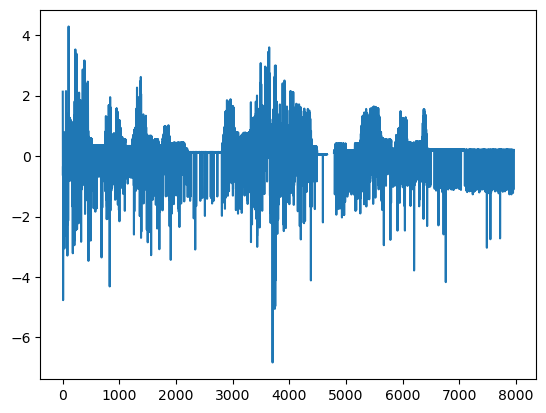

In [20]:
import matplotlib.pyplot as plt

plt.plot(
    df[partial_nan_rows].conservation_phylo.fillna(
        0,
        inplace=False,
    ).values[0]
)

In [21]:
df[full_nan_rows].shape

(101, 35)

In [22]:
def get_nan_indices(sequence):
    # Return the indices where the element is NaN
    nan_indices = [index for index, value in enumerate(sequence) if np.isnan(value)]
    return nan_indices

In [23]:
# import matplotlib.pyplot as plt 
# plt.plot(get_nan_indices(df[partial_nan_rows].head(1).conservation_phylo.values[0]))
# get_nan_indices(df[nan_rows].head(1).conservation_phylo.values[0])
# print(df[partial_nan_rows].head(1).conservation_phylo.values[0])

In [24]:
df[df.apply(lambda row: len(row.sequence) != len(row.conservation_phylo), axis=1)]

,RefSeq ID,Gene symbol,hsa-miR-16-5p,hsa-miR-106b-5p,hsa-miR-200a-3p,hsa-miR-200b-3p,hsa-miR-215-5p,hsa-let-7c-5p,hsa-miR-103a-3p,knownGene.name,...,chromosome,utr3_start,utr3_end,strand,Transcript ID,Representative transcript?,ensembl_id_no_version,sequence_origin,utr3_length,conservation_phylo
333,NM_000347,SPTB,-0.135,0.124,0.113,0.044,-0.149,0.006,NaN,uc001xht.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,[]
484,NM_000658,AIRE,-0.100,0.013,0.090,-0.113,0.358,-0.046,-0.031,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,[]
741,NM_001005409,SF3A1,0.161,0.051,-0.013,0.126,-0.170,0.028,0.040,uc021wnt.1,...,NaN,NaN,NaN,NaN,ENST00000215793.8,1.0,ENST00000215793,None,0,[]
1061,NM_001018677,FNTA,-0.266,-0.032,0.199,0.254,0.051,0.069,0.070,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,[]
1084,NM_001024668,LETMD1,-0.023,0.166,0.173,0.358,0.291,0.056,-0.079,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20490,NM_203404,AMPD2,0.352,-0.339,-0.404,-0.105,0.209,-0.067,-0.112,uc010ovr.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,[]
20507,NM_203476,PORCN,0.182,0.059,-0.064,0.046,0.360,-0.224,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,[]
20508,NM_203488,ACYP1,0.038,-0.122,-0.085,0.242,-0.023,0.016,-0.064,uc001xrf.3,...,NaN,NaN,NaN,NaN,ENST00000357971.3,1.0,ENST00000357971,None,0,[]
20551,NM_207112,HAGHL,0.044,-0.105,0.010,-0.241,-0.102,0.162,0.282,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,[]


In [25]:
df

,RefSeq ID,Gene symbol,hsa-miR-16-5p,hsa-miR-106b-5p,hsa-miR-200a-3p,hsa-miR-200b-3p,hsa-miR-215-5p,hsa-let-7c-5p,hsa-miR-103a-3p,knownGene.name,...,chromosome,utr3_start,utr3_end,strand,Transcript ID,Representative transcript?,ensembl_id_no_version,sequence_origin,utr3_length,conservation_phylo
1,NM_000017,ACADS,-0.035,0.068,-0.047,0.048,-0.225,0.250,0.094,uc001tza.4,...,chr12,121177252.0,121177811.0,+,ENST00000242592.4,1.0,ENST00000242592,RefSeq ID,560,"[1.312999963760376, 2.007999897003174, 0.08100..."
4,NM_000019,ACAT1,0.243,-0.201,0.268,-0.014,-0.013,-0.176,-0.071,uc001pjy.3,...,chr11,108018118.0,108018330.0,+,ENST00000265838.4,1.0,ENST00000265838,RefSeq ID,213,"[0.1420000046491623, 0.017999999225139618, -0...."
6,NM_000021,PSEN1,0.173,0.186,-0.046,0.175,0.112,0.057,0.000,uc001xnt.1,...,chr14,73685998.0,73690399.0,+,ENST00000344094.3,1.0,ENST00000344094,RefSeq ID,4402,"[3.859999895095825, 2.1989998817443848, -0.056..."
10,NM_000023,SGCA,NaN,NaN,0.109,-0.065,-0.152,0.152,-0.041,uc002iqi.3,...,chr17,48252799.0,48252810.0,+,ENST00000262018.3,1.0,ENST00000262018,RefSeq ID,12,"[0.6549999713897705, -0.949999988079071, 0.577..."
14,NM_000027,AGA,-0.078,-0.054,0.016,0.136,NaN,-0.090,NaN,uc003iuu.2,...,chr4,178351928.0,178352861.0,-,ENST00000264595.2,1.0,ENST00000264595,RefSeq ID,934,"[0.02800000086426735, 0.057999998331069946, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20599,NM_213646,WARS,-0.129,0.243,-0.066,0.131,-0.308,0.273,0.374,uc001yhi.1,...,chr14,100800127.0,100801211.0,-,ENST00000392882.2,1.0,ENST00000392882,RefSeq ID,1085,"[-0.8830000162124634, -1.8220000267028809, 3.5..."
20601,NM_213647,FGFR4,-0.558,0.131,0.001,-0.245,0.043,-0.021,0.041,uc003mfm.3,...,chr5,176524678.0,176525145.0,+,ENST00000292408.4,1.0,ENST00000292408,RefSeq ID,468,"[0.18700000643730164, 0.9869999885559082, -1.0..."
20602,NM_213649,SFXN4,-0.057,-0.067,0.058,0.136,-0.002,0.015,0.199,uc001ldy.3,...,chr10,120900279.0,120900753.0,-,ENST00000355697.2,1.0,ENST00000355697,RefSeq ID,475,"[2.3440001010894775, -0.625, 0.360000014305114..."
20605,NM_213651,SLC25A24,0.384,0.233,0.329,0.029,-0.200,-0.698,-0.271,uc001dvm.4,...,chr1,108676665.0,108679274.0,-,NaN,NaN,NaN,RefSeq ID,2610,"[-1.7000000476837158, 0.2280000001192093, 0.23..."
